In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from variational_lse_solver import VarLSESolver

from device_var_lse_solver import DeviceVarLSESolver
from non_dynamical_ansatz import fixed_layered_ansatz
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator
from conditioned_matrix import create_conditioned_random_matrix


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

In [2]:
# unitary representation of Paulis
I_ = np.array([[1.0, 0.0], [0.0, 1.0]])
X_ = np.array([[0.0, 1.0], [1.0, 0.0]])
Y_ = np.array([[0.0, -1.j], [1.j, 0.0]])
Z_ = np.array([[1.0, 0.0], [0.0, -1.0]])

a = ["III", "XZI", "XII"]
b = np.ones(8)/np.sqrt(8)

qubits = 3
device = Device(DeviceType.QISKIT_AER, qubits=qubits)


## Comparing dynamic circuit and non-dynamical circuit
Here we will compare the performance of the dynamical circuit and the non-dynamical circuit. We will evaluate the performance on both speed and accuracy, and the results are averaged over N runs. 

We will first solve the problem with the dynamical circuit, and thereafter let the fixed circuit perform the same computation with $d=max(d_{dyn})$. 

In [4]:
N_runs = 1
N_steps = 50
max_epoch_dyn = 10
threshold = 0.001

n_qubits = 3
depth = 10
param_shape = (n_qubits + depth*(n_qubits+n_qubits-2),)

results_dyn = np.zeros([N_runs, len(b)])
results_stat = np.zeros([N_runs, len(b)])

for i in range(N_runs):
    lse_dyn = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                epochs=max_epoch_dyn, 
                device=device) #Epochs: max circuit depth for dynamic circuit
    
    solution_dyn, _ = lse_dyn.solve()
    results_dyn[i,:] = solution_dyn

for i in range(N_runs):
    lse_stat = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                ansatz=fixed_layered_ansatz,
                weights=param_shape,
                local=True, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                device=device) 
    
    solution_stat, _ = lse_stat.solve()
    results_stat[i,:] = solution_stat

Epoch 1/10: 100%|██████████| 50/50 [00:03<00:00, 15.50it/s, best loss=0.00251, last improvement in step=47, loss=0.00728]
Increasing circuit depth.
Epoch 2/10:  92%|█████████▏| 46/50 [00:03<00:00, 15.04it/s, best loss=0.00116, last improvement in step=37, loss=0.00121]
Loss of 0.0008452886 below stopping threshold.
Returning solution.
Epoch 1/1:  80%|████████  | 40/50 [00:03<00:00, 11.98it/s, best loss=0.00133, last improvement in step=39, loss=0.00133]
Loss of 0.0006943313 below stopping threshold.
Returning solution.


In [22]:
A = 1.0 * np.kron(I_, np.kron(I_, I_)) + 0.2 * np.kron(X_, np.kron(Z_, I_)) + 0.2 * np.kron(X_, np.kron(I_, I_))
classical_solution = np.linalg.solve(A, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))


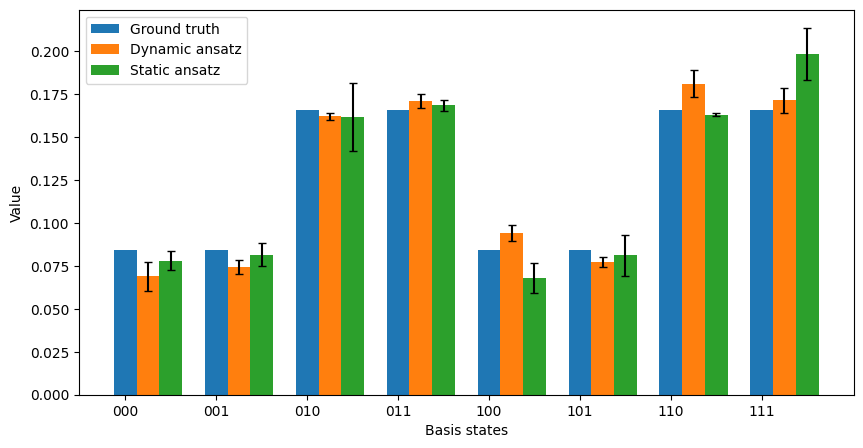

In [23]:
plt.figure(figsize=(10, 5))

x = np.arange(len(normalized_classical_solution)) 
width = 0.25 
multiplier = 0

plt.bar(x, normalized_classical_solution, width = width, label='Ground truth')
plt.bar(x + width, np.mean(results_dyn, axis=0), yerr=np.std(results_dyn,axis=0)/np.sqrt(len(results_dyn)), width=width, capsize=3, label='Dynamic ansatz')
plt.bar(x + 2*width, np.mean(results_stat, axis=0), yerr=np.std(results_stat, axis=0)/np.sqrt(len(results_stat)), width=width, capsize=3, label='Static ansatz')

plt.legend()
plt.xticks(x, ['000', '001', '010', '011', '100', '101', '110', '111'])
plt.xlabel('Basis states')
plt.ylabel('Value')
plt.show()